In [4]:
import torch

# Check if GPU is available
print(torch.cuda.is_available())  # True means GPU can be used

# Create a tensor on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.tensor([1, 2, 3], device=device)
print(x)





True
tensor([1, 2, 3], device='cuda:0')


In [5]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[]


In [1]:
import mne

# Path to your GDF file
file_path = "data/GDF file/2a_eval/A01E.gdf"

# Read the GDF file
raw = mne.io.read_raw_gdf(file_path, preload=False, verbose=True)

# Show basic info
print("\n=== Raw Info ===")
print(raw.info)

# List all channel names
print("\n=== Channel Names ===")
print(raw.ch_names)

# Show event markers
events, event_id = mne.events_from_annotations(raw)
print("\n=== Event IDs ===")
print(event_id)
print("\n=== Events ===")
print(events[:10])  # Show first 10 events

# Duration and sampling frequency
print(f"\nDuration: {raw.times[-1]:.2f} seconds")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")


Extracting EDF parameters from d:\nit\new CNN archi\data\GDF file\2a_eval\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...

=== Raw Info ===
<Info | 8 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 25 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-19 12:00:00 UTC
 nchan: 25
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: A01, sex: 0, last_name: X, birthday: 1983-01-19>
>

=== Channel Names ===
['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz

d:\programming module\python 3.10\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


In [7]:
import os
import numpy as np
import mne
from mne.filter import notch_filter, filter_data
from scipy.signal import stft
from skimage.transform import resize
from sklearn.utils import shuffle

# -------------------------------
# Helper functions
# -------------------------------
def common_average_reference(data):
    return data - np.mean(data, axis=0, keepdims=True)

def min_max_normalize(channel_data):
    return (channel_data - np.min(channel_data)) / (np.max(channel_data) - np.min(channel_data) + 1e-6)

def sliding_window_segments(data, window_size, step):
    return np.array([
        data[:, start:start+window_size]
        for start in range(0, data.shape[1] - window_size + 1, step)
    ])

def stft_spectrogram(segment, fs=250, window_size=64, overlap=50):
    f, t, Zxx = stft(segment, fs=fs, window='hann', nperseg=window_size, noverlap=overlap)
    return f, t, np.abs(Zxx)

def extract_band_spectrogram(Sxx, f, band_low, band_high):
    idx = np.where((f >= band_low) & (f <= band_high))[0]
    return Sxx[idx, :]

def resize_spectrogram(spec, target_shape=(20, 32)):
    return resize(spec, target_shape, mode='reflect', anti_aliasing=True)

def get_true_subject_id(filename):
    subject_number = int(filename[1:3])
    return subject_number - 1  # zero-indexed

# -------------------------------
# Main Preprocessing
# -------------------------------
def preprocess_gdf_folder(
        folder_path,
        selected_channels=['c3', 'cz', 'c4'],
        fs=250,
        trial_window_sec=4,
        sliding_window_sec=2,
        sliding_step_sec=0.1,
        stft_window=64,
        stft_overlap=50,
        add_gaussian_noise=False):

    X, y, subject_ids = [], [], []

    trial_window_samples = int(trial_window_sec * fs)
    sliding_window_samples = int(sliding_window_sec * fs)
    sliding_step_samples = int(sliding_step_sec * fs)

    # Label mapping (4 classes)
    event_code_to_label = {
        769: 0,   # Left
        770: 1,   # Right
        771: 2,   # Foot
        772: 3    # Tongue
    }

    for filename in sorted(os.listdir(folder_path)):
        if not filename.endswith('.gdf'):
            continue

        filepath = os.path.join(folder_path, filename)
        subject_id = get_true_subject_id(filename)

        try:
            with mne.utils.use_log_level('ERROR'):
                raw = mne.io.read_raw_gdf(filepath, preload=True)
        except Exception as e:
            print(f"❌ Failed to load {filename}: {e}")
            continue

        print(f"\n📄 Processing {filename} (Subject {subject_id})")

        # --- Channel Selection ---
        data = raw.get_data()
        channel_names = raw.info['ch_names']
        cleaned_names = [ch.lower().replace('eeg:', '').replace('eeg-', '').strip()
                         for ch in channel_names]

        try:
            idx = [cleaned_names.index(ch.lower()) for ch in selected_channels]
        except ValueError as e:
            print(f"⚠ Skipping {filename} due to missing channels: {e}")
            continue

        data_sel = data[idx, :]

        # --- Filters ---
        data_car = common_average_reference(data_sel)
        with mne.utils.use_log_level('WARNING'):
            data_notch = notch_filter(data_car, fs, freqs=50, method='fir')
            data_band = filter_data(data_notch, fs,
                                    l_freq=8, h_freq=30, method='fir',
                                    phase='zero-double', fir_window='hamming')

        data_norm = np.array([min_max_normalize(ch) for ch in data_band])

        # --- Annotations ---
        annotations = raw.annotations
        event_onsets = (annotations.onset * fs).astype(int)
        event_descriptions = annotations.description

        # Artifact trial markers
        artifact_times = [int((onset + 2) * fs) for onset, desc in zip(annotations.onset, event_descriptions) if desc == '1023']

        trials_in_file = 0

        # Process trials: look for trial start (768) then next cue (769–772)
        for i, (onset, desc) in enumerate(zip(event_onsets, event_descriptions)):
            if desc != '768':  # only trial start markers
                continue

            # Look ahead for the next cue event
            if i+1 < len(event_descriptions):
                try:
                    cue_code = int(event_descriptions[i+1].strip())
                except:
                    continue
                if cue_code not in event_code_to_label:
                    continue
                label = event_code_to_label[cue_code]
            else:
                continue

            start_sample = onset + 2*fs  # 2s after trial start
            end_sample = start_sample + trial_window_samples

            # Skip if artifact or overflow
            if any(abs(start_sample - a) < trial_window_samples for a in artifact_times):
                continue
            if end_sample > data_norm.shape[1]:
                continue

            # --- Trial Data ---
            trial = data_norm[:, start_sample:end_sample]

            # --- Sliding Windows ---
            segments = sliding_window_segments(trial,
                                               sliding_window_samples,
                                               sliding_step_samples)

            for segment in segments:
                channel_imgs = []
                for ch in range(len(selected_channels)):
                    sig = segment[ch, :]
                    f, t, Sxx = stft_spectrogram(sig, fs=fs,
                                                 window_size=stft_window,
                                                 overlap=stft_overlap)

                    mu_spec = extract_band_spectrogram(Sxx, f, 8, 14)
                    mu_resized = resize_spectrogram(mu_spec)

                    beta_spec = extract_band_spectrogram(Sxx, f, 16, 30)
                    beta_resized = resize_spectrogram(beta_spec)

                    combined_spec = np.vstack([mu_resized, beta_resized])  # (40, 32)
                    channel_imgs.append(combined_spec)

                img = np.vstack(channel_imgs)  # (120, 32)
                img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)  # (120, 32, 3)

                if add_gaussian_noise:
                    noise = np.random.normal(0, 0.01, img.shape)
                    img += noise

                img = (img - np.mean(img)) / (np.std(img) + 1e-6)

                X.append(img)
                y.append(label)
                subject_ids.append(subject_id)
                trials_in_file += 1

        print(f"✅ Extracted {trials_in_file} samples from {filename}")

    # Final arrays
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)
    subject_ids = np.array(subject_ids, dtype=np.int64)

    if len(X) > 0:
        X, y, subject_ids = shuffle(X, y, subject_ids, random_state=42)

    print(f"\n🎯 Finished preprocessing.")
    print(f"🟢 X shape: {X.shape}, y shape: {y.shape}, subject_ids shape: {subject_ids.shape}")
    return X, y, subject_ids


In [8]:

folder = "d:/nit/new CNN archi/data/GDF file/2a_train"   # path where A01T.gdf ... A09T.gdf are stored
X, y, subject_ids = preprocess_gdf_folder(folder)

np.save("X_preprocessed_2a.npy", X)
np.save("y_preprocessed_2a.npy", y)
np.save("subject_ids_2a.npy", subject_ids)




📄 Processing A01T.gdf (Subject 0)
✅ Extracted 5733 samples from A01T.gdf

📄 Processing A02T.gdf (Subject 1)
✅ Extracted 5670 samples from A02T.gdf

📄 Processing A03T.gdf (Subject 2)
✅ Extracted 5670 samples from A03T.gdf

📄 Processing A04T.gdf (Subject 3)
✅ Extracted 5502 samples from A04T.gdf

📄 Processing A05T.gdf (Subject 4)
✅ Extracted 5502 samples from A05T.gdf

📄 Processing A06T.gdf (Subject 5)
✅ Extracted 4599 samples from A06T.gdf

📄 Processing A07T.gdf (Subject 6)
✅ Extracted 5691 samples from A07T.gdf

📄 Processing A08T.gdf (Subject 7)
✅ Extracted 5544 samples from A08T.gdf

📄 Processing A09T.gdf (Subject 8)
✅ Extracted 4977 samples from A09T.gdf

🎯 Finished preprocessing.
🟢 X shape: (48888, 120, 32, 3), y shape: (48888,), subject_ids shape: (48888,)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torchsummary import summary


In [7]:
class EnhancedEEGCNNV3(nn.Module):
    def __init__(self, num_classes=4):
        super(EnhancedEEGCNNV3, self).__init__()

        self.act = nn.SiLU()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.se_fc1 = nn.Linear(256, 64)
        self.se_fc2 = nn.Linear(64, 256)

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 8 * 2, 256)  # Matches output after conv4
        self.fc2 = nn.Linear(256, num_classes)

    def se_block(self, x):
        b, c, _, _ = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.act(self.se_fc1(y))
        y = torch.sigmoid(self.se_fc2(y)).view(b, c, 1, 1)
        return x * y

    def forward(self, x):
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.act(self.bn4(self.conv4(x)))
        x = self.se_block(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(self.act(self.fc1(x)))
        x = self.fc2(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedEEGCNNV3(num_classes=4).to(device)
dummy_input = torch.randn(2, 3, 120, 32).to(device)
output = model(dummy_input)
print(output.shape)  # ✅ torch.Size([2, 4]
from torchsummary import summary
summary(model, input_size=(3, 120, 32))


torch.Size([2, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 60, 16]           2,432
       BatchNorm2d-2           [-1, 32, 60, 16]              64
              SiLU-3           [-1, 32, 60, 16]               0
            Conv2d-4            [-1, 64, 30, 8]          18,496
       BatchNorm2d-5            [-1, 64, 30, 8]             128
              SiLU-6            [-1, 64, 30, 8]               0
            Conv2d-7           [-1, 128, 15, 4]          73,856
       BatchNorm2d-8           [-1, 128, 15, 4]             256
              SiLU-9           [-1, 128, 15, 4]               0
           Conv2d-10            [-1, 256, 8, 2]         295,168
      BatchNorm2d-11            [-1, 256, 8, 2]             512
             SiLU-12            [-1, 256, 8, 2]               0
AdaptiveAvgPool2d-13            [-1, 256, 1, 1]               0
           Linear-14

In [12]:
def augment_spec(x, time_mask=10, freq_mask=5):
    """
    Apply random time and frequency masking to a spectrogram (SpecAugment style).
    x: Tensor of shape (C=3, H=120, W=32)
    """
    c, h, w = x.shape
    x_aug = x.clone()

    # Time masking (mask a contiguous block along H)
    if torch.rand(1).item() < 0.5:
        t = torch.randint(0, h - time_mask, (1,)).item()
        x_aug[:, t:t+time_mask, :] = 0

    # Frequency masking (mask a contiguous block along W)
    if torch.rand(1).item() < 0.5:
        f = torch.randint(0, w - freq_mask, (1,)).item()
        x_aug[:, :, f:f+freq_mask] = 0

    return x_aug


In [13]:
# ---- Load preprocessed data ----
X = np.load("X_preprocessed_2a.npy")
y = np.load("y_preprocessed_2a.npy")

In [14]:
class LazyEEGDataset(Dataset):
    def __init__(self, X_path, y_path, indices):
        self.X = np.load(X_path, mmap_mode='r')   # memory-mapped lazy loading
        self.y_full = np.load(y_path)             # keep full label array
        self.indices = indices

        # ✅ Check labels on the full dataset, not just the split
        unique_labels = np.unique(self.y_full)
        if not np.array_equal(unique_labels, np.arange(4)):
            raise ValueError(f"Labels must be in [0,1,2,3], but got {unique_labels}")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        x = self.X[i].transpose(2, 0, 1)  # (C, H, W)
        y = self.y_full[i]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


def create_dataloaders_with_test(X_path, y_path, batch_size=16):
    y_full = np.load(y_path)
    total_indices = np.arange(len(y_full))

    # ✅ Stratified split ensures all 4 labels appear
    trainval_idx, test_idx = train_test_split(
        total_indices, test_size=0.15, stratify=y_full, random_state=42
    )

    train_idx, val_idx = train_test_split(
        trainval_idx, test_size=0.176, stratify=y_full[trainval_idx], random_state=42
    )

    # Create datasets
    train_dataset = LazyEEGDataset(X_path, y_path, train_idx)
    val_dataset   = LazyEEGDataset(X_path, y_path, val_idx)
    test_dataset  = LazyEEGDataset(X_path, y_path, test_idx)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader


In [15]:
def evaluate_metrics(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    avg_loss = total_loss / len(loader)

    return acc, prec, rec, f1, avg_loss


def train_model(model, train_loader, val_loader, device, epochs=300, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=10, factor=0.5)

    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        all_preds, all_labels = [], []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        # Compute training metrics
        train_acc = accuracy_score(all_labels, all_preds)
        train_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        train_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        train_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        train_loss = total_loss / len(train_loader)

        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Validation
        val_acc, val_prec, val_rec, val_f1, val_loss = evaluate_metrics(model, val_loader, device)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        # Learning rate adjustment
        prev_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_acc)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr != prev_lr:
            print(f"🔁 LR changed from {prev_lr:.6f} to {new_lr:.6f}")

        # Logging
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss : {train_loss:.4f}")
        print(f"  Train Acc  : {train_acc:.4f}")
        print(f"  Precision  : {train_precision:.4f}")
        print(f"  Recall     : {train_recall:.4f}")
        print(f"  F1 Score   : {train_f1:.4f}")
        print(f"  Val Loss   : {val_loss:.4f}")
        print(f"  Val Acc    : {val_acc:.4f}")
        print(f"  LR         : {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)

    torch.save(model.state_dict(), "cnn_eeg_model.pth")
    print("✅ Model saved as cnn_eeg_model_1.pth")
    return train_accs, val_accs, train_losses, val_losses


In [16]:
def evaluate_on_test(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print("\n✅ Global Test Evaluation:")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    # Per-class stats
    num_classes = cm.shape[0]
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        print(f"\nClass {i}: TP={TP}, TN={TN}, FP={FP}, FN={FN}")


In [17]:
def evaluate_per_subject(model, X_path, y_path, subject_path, device):
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    import torch.nn as nn

    # Load data
    X = np.load(X_path, mmap_mode='r')
    y = np.load(y_path)
    subject_ids = np.load(subject_path)
    unique_subjects = np.unique(subject_ids)

    criterion = nn.CrossEntropyLoss()

    # store overall metrics + confusion matrices
    all_acc, all_prec, all_rec, all_f1 = [], [], [], []
    cm_sum = None  # to accumulate confusion matrices

    for subj in unique_subjects:
        indices = np.where(subject_ids == subj)[0]
        X_subj = torch.tensor(X[indices].transpose(0, 3, 1, 2), dtype=torch.float32).to(device)
        y_subj = torch.tensor(y[indices], dtype=torch.long).to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(X_subj)
            loss = criterion(outputs, y_subj)
            _, preds = torch.max(outputs, 1)

        all_preds = preds.cpu().numpy()
        all_labels = y_subj.cpu().numpy()

        # Metrics
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)

        # Add to running totals
        all_acc.append(acc)
        all_prec.append(prec)
        all_rec.append(rec)
        all_f1.append(f1)
        if cm_sum is None:
            cm_sum = cm.astype(np.float64)
        else:
            cm_sum += cm

        print(f"\n🎓 Subject {subj} — Evaluation:")
        print(f"Loss          : {loss.item():.4f}")
        print(f"Accuracy      : {acc:.4f}")
        print(f"Precision     : {prec:.4f}")
        print(f"Recall        : {rec:.4f}")
        print(f"F1 Score      : {f1:.4f}")
        print("Confusion Matrix:\n", cm)

    # ---- AVERAGE RESULTS ----
    print("\n📊 === Overall Averages Across Subjects ===")
    print(f"Mean Accuracy : {np.mean(all_acc):.4f}")
    print(f"Mean Precision: {np.mean(all_prec):.4f}")
    print(f"Mean Recall   : {np.mean(all_rec):.4f}")
    print(f"Mean F1 Score : {np.mean(all_f1):.4f}")

    # Average confusion matrix
    avg_cm = cm_sum / len(unique_subjects)
    print("\n📊 Average Confusion Matrix (across subjects):\n", avg_cm.astype(int))

    # Plot heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues')
    plt.title("Average Confusion Matrix (All Subjects)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [18]:
def plot_training_curves(train_accuracies, val_accuracies, train_losses, val_losses):
    best_epoch = np.argmax(val_accuracies)
    best_val_acc = val_accuracies[best_epoch]

    plt.figure(figsize=(14, 5))

    # --- Accuracy curve ---
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Acc', marker='o')
    plt.plot(val_accuracies, label='Val Acc', marker='s')
    plt.axvline(best_epoch, linestyle='--', color='gray', label=f'Best Epoch ({best_epoch+1})')

    # Highlight best val acc with an 'x'
    plt.plot(best_epoch, best_val_acc, marker='x', markersize=10, color='red', label=f'Best Val Acc {best_val_acc:.4f}')

    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Loss curve ---
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='s')
    plt.axvline(best_epoch, linestyle='--', color='gray', label=f'Best Epoch ({best_epoch+1})')

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Epoch 1/120
  Train Loss : 1.2828
  Train Acc  : 0.3857
  Precision  : 0.3826
  Recall     : 0.3848
  F1 Score   : 0.3810
  Val Loss   : 1.2198
  Val Acc    : 0.4241
  LR         : 0.001000
--------------------------------------------------
Epoch 2/120
  Train Loss : 1.2038
  Train Acc  : 0.4366
  Precision  : 0.4356
  Recall     : 0.4361
  F1 Score   : 0.4351
  Val Loss   : 1.1707
  Val Acc    : 0.4534
  LR         : 0.001000
--------------------------------------------------
Epoch 3/120
  Train Loss : 1.1533
  Train Acc  : 0.4634
  Precision  : 0.4625
  Recall     : 0.4630
  F1 Score   : 0.4624
  Val Loss   : 1.1191
  Val Acc    : 0.4904
  LR         : 0.001000
--------------------------------------------------
Epoch 4/120
  Train Loss : 1.0958
  Train Acc  : 0.5029
  Precision  : 0.5024
  Recall     : 0.5027
  F1 Score   : 0.5024
  Val Loss   : 1.0772
  Val Acc    : 0.5127
  LR         : 0.001000
--------------------------------------------------
Epoch 5/120
  Train Loss : 1.0318
  

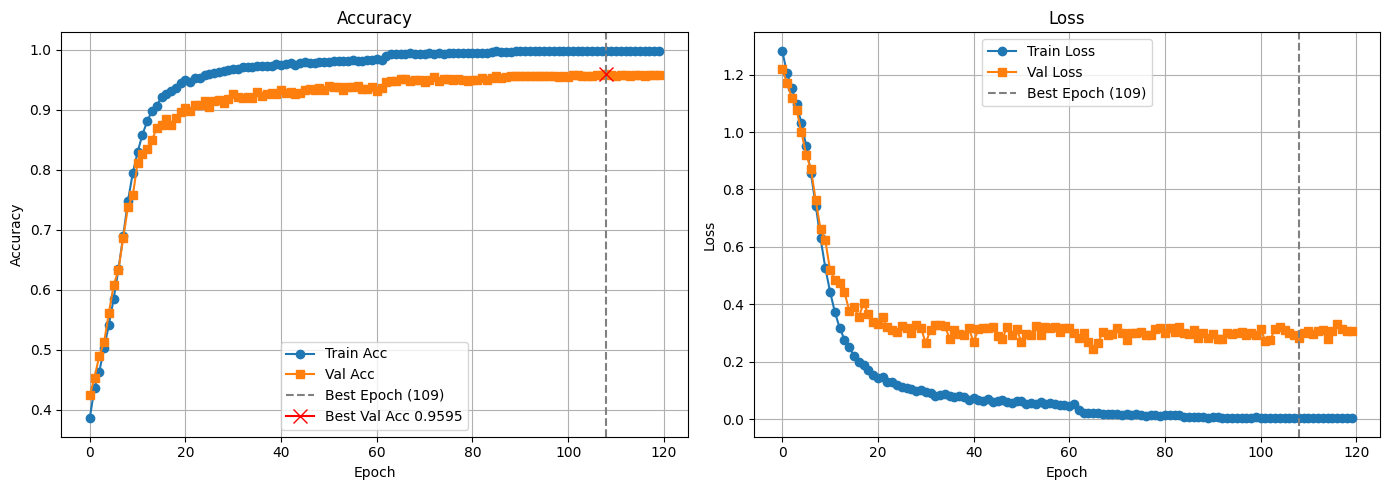

In [19]:
if __name__ == "__main__":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = EnhancedEEGCNNV3().to(device)

    train_loader, val_loader, test_loader = create_dataloaders_with_test(
        'X_preprocessed_2a.npy',
        'y_preprocessed_2a.npy',
        batch_size=16
    )

    train_accs, val_accs, train_losses, val_losses = train_model(
        model, train_loader, val_loader, device, epochs=120
    )

    plot_training_curves(train_accs, val_accs, train_losses, val_losses)




✅ Global Test Evaluation:
Accuracy       : 0.9585
Precision      : 0.9587
Recall         : 0.9586
F1 Score       : 0.9586
Confusion Matrix:
 [[1744   27   12   19]
 [  39 1781   19   23]
 [  27   35 1722   24]
 [  31   29   19 1783]]

Class 0: TP=1744, TN=5435, FP=97, FN=58

Class 1: TP=1781, TN=5381, FP=91, FN=81

Class 2: TP=1722, TN=5476, FP=50, FN=86

Class 3: TP=1783, TN=5406, FP=66, FN=79

🎓 Subject 0 — Evaluation:
Loss          : 0.0615
Accuracy      : 0.9911
Precision     : 0.9912
Recall        : 0.9911
F1 Score      : 0.9911
Confusion Matrix:
 [[1443    4    2    0]
 [  14 1433    2    0]
 [   7    9 1408    4]
 [   5    2    2 1398]]

🎓 Subject 1 — Evaluation:
Loss          : 0.1221
Accuracy      : 0.9832
Precision     : 0.9833
Recall        : 0.9833
F1 Score      : 0.9833
Confusion Matrix:
 [[1374   18    9    6]
 [  11 1422    9    7]
 [   4    6 1375    1]
 [   8    6   10 1404]]

🎓 Subject 2 — Evaluation:
Loss          : 0.0405
Accuracy      : 0.9931
Precision     : 0.99

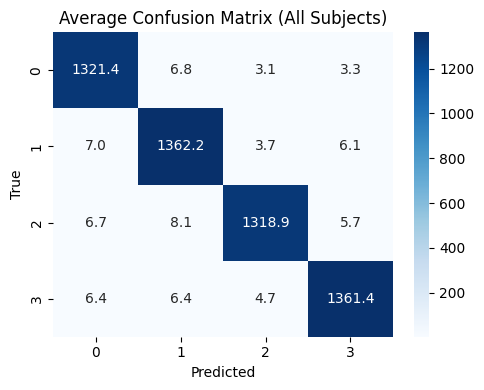

In [20]:
# ✅ Global test set evaluation
evaluate_on_test(model, test_loader, device)

    # ✅ Per-subject evaluation with confusion matrix
evaluate_per_subject(
    model,
    'X_preprocessed_2a.npy',
    'y_preprocessed_2a.npy',
    'subject_ids_2a.npy',
    device
)

In [21]:
import numpy as np

# Load the preprocessed data
X = np.load('X_preprocessed_2a.npy', mmap_mode='r')  # memory-mapped
y = np.load('y_preprocessed_2a.npy')

# Shapes
print("X shape:", X.shape)  # should be (48741, 120, 32, 3)
print("y shape:", y.shape)  # should be (48741,)

# Data types
print("X dtype:", X.dtype)
print("y dtype:", y.dtype)

# Quick check: first sample
print("First X sample min/max:", X[0].min(), X[0].max())
print("First y sample:", y[0])

# Unique labels
print("Unique labels in y:", np.unique(y))


X shape: (48888, 120, 32, 3)
y shape: (48888,)
X dtype: float32
y dtype: int64
First X sample min/max: -1.2039104 4.325581
First y sample: 0
Unique labels in y: [0 1 2 3]



🎓 Subject 0 — Evaluation:
Loss          : 0.0615
Accuracy      : 0.9911
Precision     : 0.9912
Recall        : 0.9911
F1 Score      : 0.9911
Confusion Matrix:
 [[1443    4    2    0]
 [  14 1433    2    0]
 [   7    9 1408    4]
 [   5    2    2 1398]]

🎓 Subject 1 — Evaluation:
Loss          : 0.1221
Accuracy      : 0.9832
Precision     : 0.9833
Recall        : 0.9833
F1 Score      : 0.9833
Confusion Matrix:
 [[1374   18    9    6]
 [  11 1422    9    7]
 [   4    6 1375    1]
 [   8    6   10 1404]]

🎓 Subject 2 — Evaluation:
Loss          : 0.0405
Accuracy      : 0.9931
Precision     : 0.9932
Recall        : 0.9931
F1 Score      : 0.9931
Confusion Matrix:
 [[1444    2    2    1]
 [   0 1420    0    8]
 [  11    5 1366    4]
 [   0    3    3 1401]]

🎓 Subject 3 — Evaluation:
Loss          : 0.1164
Accuracy      : 0.9840
Precision     : 0.9840
Recall        : 0.9840
F1 Score      : 0.9840
Confusion Matrix:
 [[1283   10    1    8]
 [   2 1379    4   22]
 [   7    8 1384    8]
 [  12  

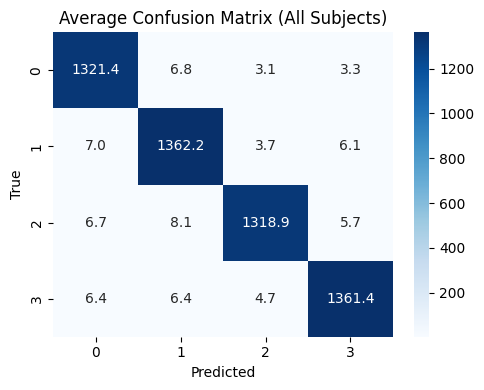

In [22]:
evaluate_per_subject(
    model,
    'X_preprocessed_2a.npy',
    'y_preprocessed_2a.npy',
    'subject_ids_2a.npy',
    device
)

In [ ]:
state_dict = torch.load("cnn_eeg_model.pth", map_location="cpu")
print(state_dict.keys())


NameError: name 'torch' is not defined

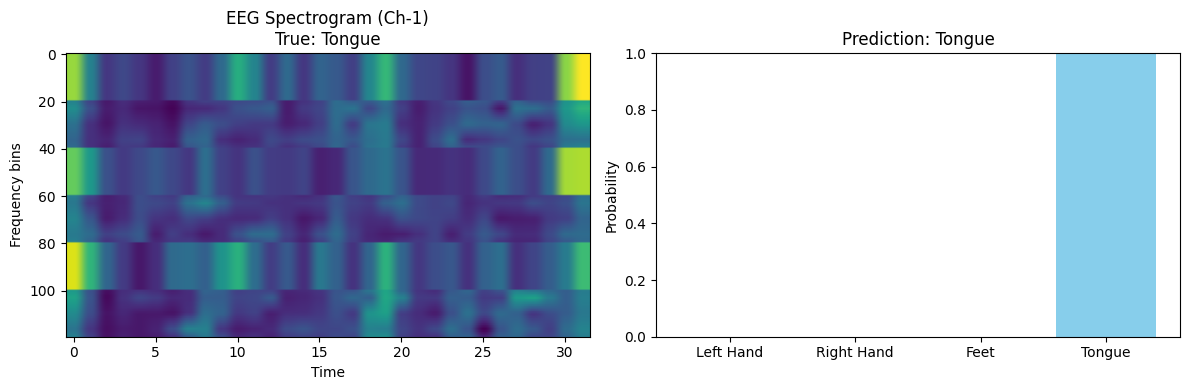


Overall Dataset Accuracy: 0.9874


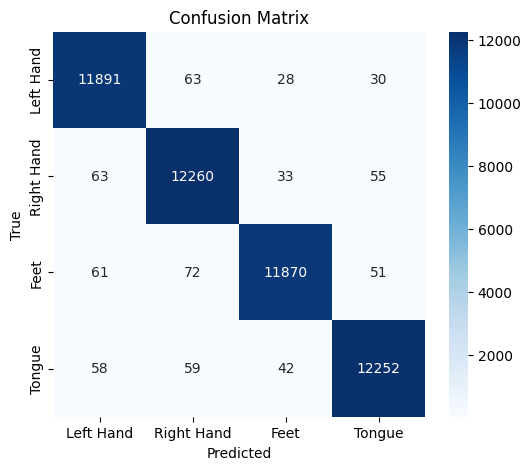

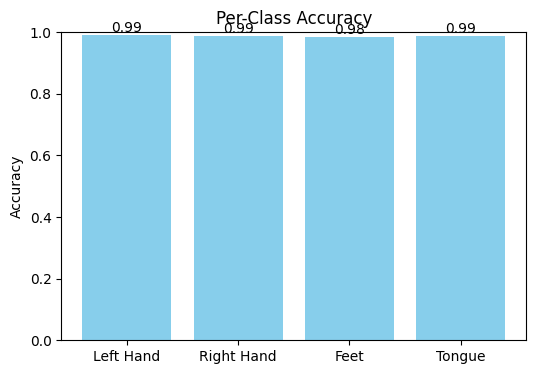

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load Data & Model
# -----------------------------
X = np.load("X_preprocessed_2a.npy")  # (48888, 120, 32, 3)
y = np.load("y_preprocessed_2a.npy")  # (48888,)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedEEGCNNV3(num_classes=4).to(device)
model.load_state_dict(torch.load("cnn_eeg_model.pth", map_location=device))
model.eval()

class_map = {0: "Left Hand", 1: "Right Hand", 2: "Feet", 3: "Tongue"}

# -----------------------------
# Helper: Predict & plot one trial
# -----------------------------
def predict_trial(idx):
    X_trial = X[idx]
    y_true = y[idx]

    if X_trial.shape[-1] == 3:
        X_trial = np.transpose(X_trial, (2, 0, 1))  # (3, 120, 32)

    X_tensor = torch.tensor(X_trial, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(X_tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
        pred_class = np.argmax(probs)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].imshow(X_trial[0], aspect="auto", cmap="viridis")
    axes[0].set_title(f"EEG Spectrogram (Ch-1)\nTrue: {class_map[y_true]}")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Frequency bins")

    axes[1].bar(class_map.values(), probs, color="skyblue")
    axes[1].set_ylim(0, 1)
    axes[1].set_title(f"Prediction: {class_map[pred_class]}")
    axes[1].set_ylabel("Probability")

    plt.tight_layout()
    plt.show()

# -----------------------------
# Interactive Trial Selection
# -----------------------------
while True:
    idx_input = input(f"Enter trial index (0-{len(X)-1}) or 'q' to quit: ")
    if idx_input.lower() == 'q':
        break
    if not idx_input.isdigit():
        print("Please enter a valid integer index.")
        continue
    idx = int(idx_input)
    if idx < 0 or idx >= len(X):
        print("Index out of range.")
        continue
    predict_trial(idx)

# -----------------------------
# Evaluate Dataset in Batches (batch_size=16)
# -----------------------------
from sklearn.metrics import confusion_matrix, accuracy_score

batch_size = 16
preds = []

if X.shape[-1] == 3:
    X_eval = np.transpose(X, (0, 3, 1, 2))
else:
    X_eval = X

with torch.no_grad():
    for i in range(0, len(X_eval), batch_size):
        X_batch = torch.tensor(X_eval[i:i+batch_size], dtype=torch.float32).to(device)
        logits = model(X_batch)
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        preds.append(batch_preds)

preds = np.concatenate(preds)
overall_acc = accuracy_score(y, preds)
print(f"\nOverall Dataset Accuracy: {overall_acc:.4f}")

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_map.values(), yticklabels=class_map.values(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# Per-Class Accuracy
# -----------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(6, 4))
plt.bar(class_map.values(), per_class_acc, color="skyblue")
plt.ylim(0, 1)
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy")
for i, v in enumerate(per_class_acc):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.show()


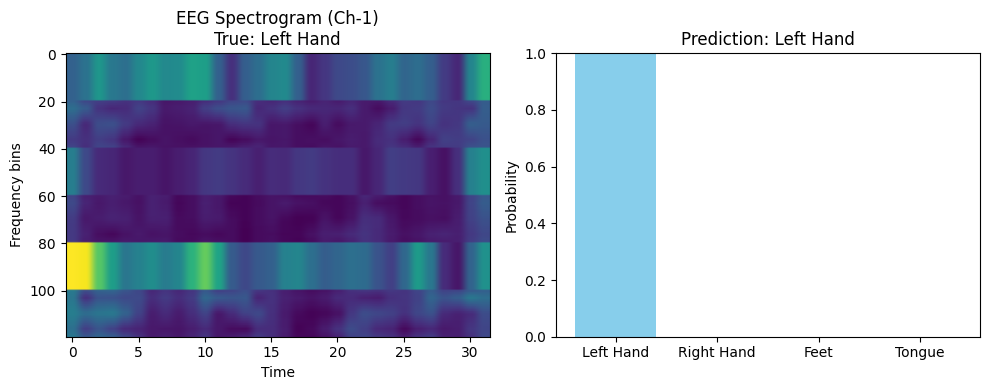

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from ipywidgets import widgets, VBox, HBox
from IPython.display import display

# -----------------------------
# Load Data & Model
# -----------------------------
X = np.load("X_preprocessed_2a.npy")  # (n_samples, 120, 32, 3)
y = np.load("y_preprocessed_2a.npy")  # (n_samples,)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedEEGCNNV3(num_classes=4).to(device)
model.load_state_dict(torch.load("cnn_eeg_model_best_2a.pth", map_location=device))
model.eval()

class_map = {0: "Left Hand", 1: "Right Hand", 2: "Feet", 3: "Tongue"}

# -----------------------------
# Helper: Display Trial
# -----------------------------
def show_trial(idx):
    X_trial = X[idx]
    y_true = y[idx]

    if X_trial.shape[-1] == 3:
        X_trial = np.transpose(X_trial, (2, 0, 1))  # (3, 120, 32)

    X_tensor = torch.tensor(X_trial, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(X_tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
        pred_class = np.argmax(probs)

    plt.figure(figsize=(10, 4))

    # EEG Spectrogram
    plt.subplot(1, 2, 1)
    plt.imshow(X_trial[0], aspect="auto", cmap="viridis")
    plt.title(f"EEG Spectrogram (Ch-1)\nTrue: {class_map[y_true]}")
    plt.xlabel("Time")
    plt.ylabel("Frequency bins")

    # Prediction Probabilities
    plt.subplot(1, 2, 2)
    plt.bar(class_map.values(), probs, color="skyblue")
    plt.ylim(0, 1)
    plt.title(f"Prediction: {class_map[pred_class]}")
    plt.ylabel("Probability")

    plt.tight_layout()
    plt.show()

# -----------------------------
# Widgets for scrolling
# -----------------------------
trial_idx = widgets.IntText(value=0, description='Trial:', layout=widgets.Layout(width='150px'))
prev_btn = widgets.Button(description="Previous", button_style='info')
next_btn = widgets.Button(description="Next", button_style='info')

def update_trial(change):
    idx = trial_idx.value
    if idx < 0: idx = 0
    if idx >= len(X): idx = len(X)-1
    trial_idx.value = idx
    show_trial(idx)

def prev_clicked(b):
    trial_idx.value -= 1
    update_trial(None)

def next_clicked(b):
    trial_idx.value += 1
    update_trial(None)

prev_btn.on_click(prev_clicked)
next_btn.on_click(next_clicked)
trial_idx.observe(update_trial, names='value')

display(HBox([prev_btn, next_btn, trial_idx]))

# Show initial trial
show_trial(trial_idx.value)
